# Entraînement des modèles de classification

## 1 - Manipulation et preprocessing des données

On définit une classe pour manipuler le dataset d'images de HappyBud.

In [54]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms_v2
from PIL import Image
import pathlib

dataset = pd.read_csv("dataset/tomato_dataset_v2.csv", index_col=0)

classes = dataset["class"].unique()
classes

array(['early_blight', 'healthy', 'late_blight', 'leaf_miner',
       'nutrient_deficiency', 'spotted_wilt_virus', 'septoria_leaf_spot',
       'verticillium_wilt', 'mosaic_virus', 'yellow_leaf_curl_virus'],
      dtype=object)

In [56]:
class HappyBudDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, classes, subset="train", class_column="class", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file.
            root_dir (str): Root directory containing train, val, and test folders.
            subset (str): One of 'train', 'val', or 'test'.
            transform (callable, optional): Transformations to apply to images.
        """
        self.df = dataframe
        self.class_column = class_column

        self.df[class_column] = self.df[class_column].astype(pd.CategoricalDtype(categories=classes))

        # Filter dataset based on 'train', 'val', or 'test'
        self.df = self.df[self.df["subset"] == subset]

        # One-hot encoding of labels
        self.labels = pd.get_dummies(self.df[class_column])

        self.root_dir = pathlib.Path(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_name = self.df["filename"].iloc[idx]
        img_path = self.root_dir / img_name

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Load labels (convert to tensor)
        labels = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float32)

        return image, labels


# Define transformations
transform = transforms_v2.Compose(
    [
        transforms_v2.ToImage(),  # Convert to image tensor
        transforms_v2.ToDtype(torch.float32, scale=True),  # Convert dtype to float32
        transforms_v2.Resize((224, 224)),  # Resize images to match model input
    ]
)

# Create dataset
root_dir = "dataset/tomato/"

train_dataset = HappyBudDataset(dataset, root_dir, classes, subset="train", transform=transform)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Test the dataset
for images, labels in train_loader:
    print(images.shape)  # Should be (batch_size, 3, 224, 224)
    print(labels.shape)  # Should be (batch_size, num_classes)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32, 10])


On définit un pipeline pour l'entraînement des données. Ce pipeline se base sur cette
[page](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html)
qui définit les bonnes pratiques pour différentes tâches de vision. On se base aussi en
partie sur le [pipeline](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights)
qui a été utilisé pour entraîner le modèle sur ImageNet1K.

Voici les étapes du pipeline:
- Conversion en tenseur
- Changement du type de données pour float32
- Redimensionnement en images 256x256 (légèrement plus gros que l'entrée)
- Rotation aléatoire
- Réflexion horizontale aléatoire
- Recadrage (crop) aléatoire en 224x224
- Normalisation selon la moyenne et l'écart type de ImageNet1K

In [3]:
# Training pipeline
transformations = [
    # Conversion to float32 image tensor
    transforms_v2.ToImage(),
    transforms_v2.ToDtype(torch.float32, scale=True),
    # Data augmentation
    transforms_v2.Resize((256, 256), antialias=True),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.RandomRotation(
        degrees=(0, 360)
    ),  # , interpolation=transforms_v2.InterpolationMode.BILINEAR),
    transforms_v2.RandomCrop(size=(224, 224)),
    # Normalization for ViT, valeurs de ImageNet1K
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

training_pipeline = transforms_v2.Compose(transformations)

# Pour l'affichage des images, on ne doit pas normaliser
dummy_pipeline = transforms_v2.Compose(transformations[:-1])

Visualisation des images après les transformations.

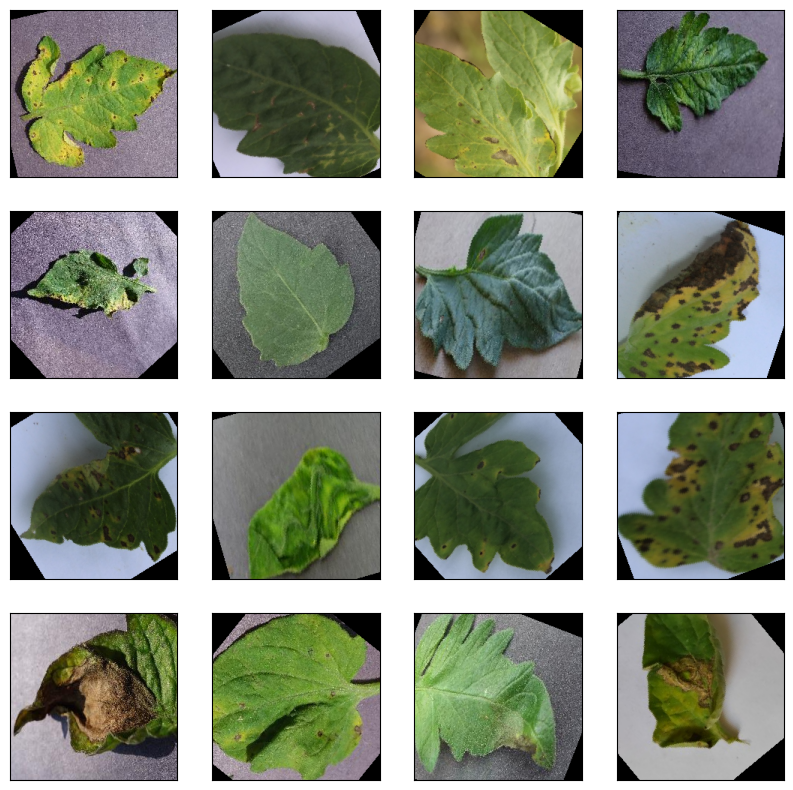

In [57]:
# Visualisation de quelques images après passage du pipeline
import matplotlib.pyplot as plt

dummy_train_dataset = HappyBudDataset(
    dataset, root_dir, classes, subset="train", transform=dummy_pipeline
)
dummy_train_loader = DataLoader(dummy_train_dataset, batch_size=16, shuffle=True)

images, labels = next(iter(dummy_train_loader))

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, image in enumerate(images):
    ax = axes.flatten()[i]
    ax.imshow(image.moveaxis(0, -1))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

## 2 - Entraînement du modèle (avec poids)

### 2.1 - Entraînement du modèle

In [52]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# import timm
from torchvision.models import mobilenet_v3_large

In [ ]:
# Create dataset
csv_path = "dataset/tomato_dataset_v2.csv"
root_dir = "dataset/tomato/"

# Load datasets
train_dataset = HappyBudDataset(
    dataset, root_dir=root_dir, classes, subset="train", transform=training_pipeline
)
test_dataset = HappyBudDataset(
    dataset, root_dir=root_dir, classes, subset="test", transform=training_pipeline
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
# Load pretrained MobileNet v3
num_labels = len(train_dataset.labels.columns)  # Get number of labels (e.g., 8)

model = mobilenet_v3_large(weights="IMAGENET1K_V1")  # Load a pretrained model
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, num_labels
)  # Modify last layer

In [15]:
# Calcul du nombre d'images par classes
image_numbers = train_dataset.df["class"].value_counts()[train_dataset.labels.columns]
image_numbers

early_blight               743
healthy                   1745
late_blight               1508
leaf_miner                 717
mosaic_virus               261
nutrient_deficiency        120
septoria_leaf_spot        3160
spotted_wilt_virus         362
verticillium_wilt          540
yellow_leaf_curl_virus    3750
Name: count, dtype: int64

In [16]:
# Calcul du poids pour la calibration
weights = torch.tensor(image_numbers.sum() / (image_numbers.values * len(image_numbers)))
weights

tensor([ 1.7370,  0.7396,  0.8558,  1.8000,  4.9448, 10.7550,  0.4084,  3.5652,
         2.3900,  0.3442], dtype=torch.float64)

In [17]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

cuda


In [18]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0.0

        for images, labels in train_loader:
            # Compute loss
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # Logits
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Compute number of correct images
            prediction = torch.argmax(outputs, axis=1)
            label = torch.argmax(labels, axis=1)
            correct += (prediction == label).sum()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / len(train_loader.dataset)

        print(
            f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}"
        )


# Train for 10 epochs
train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch [1/10] | Train Loss: 0.6759 | Train Accuracy: 0.7888
Epoch [2/10] | Train Loss: 0.2918 | Train Accuracy: 0.8997
Epoch [3/10] | Train Loss: 0.2324 | Train Accuracy: 0.9194
Epoch [4/10] | Train Loss: 0.1946 | Train Accuracy: 0.9293
Epoch [5/10] | Train Loss: 0.1635 | Train Accuracy: 0.9387
Epoch [6/10] | Train Loss: 0.1674 | Train Accuracy: 0.9427
Epoch [7/10] | Train Loss: 0.1462 | Train Accuracy: 0.9497
Epoch [8/10] | Train Loss: 0.1331 | Train Accuracy: 0.9523
Epoch [9/10] | Train Loss: 0.1136 | Train Accuracy: 0.9551
Epoch [10/10] | Train Loss: 0.1043 | Train Accuracy: 0.9630


In [19]:
import pathlib

pathlib.Path("models").mkdir(exist_ok=True)

# Save model
torch.save(model.state_dict(), "models/tomato_model_2025_03_26_weights.pt")

### 2.2 - Validation du modèle sur les données de test

In [20]:
import torch

# Load fine-tuned ViT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(test_dataset.labels.columns)  # Get number of labels (e.g., 8)

model = mobilenet_v3_large(weights="IMAGENET1K_V1")  # Load a pretrained model
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, num_labels
)  # Modify last layer Modify last layer

model.load_state_dict(
    torch.load(
        "models/tomato_model_2025_03_26_weights.pt",
        map_location=device,
        weights_only=True,
    )
)

<All keys matched successfully>

In [21]:
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()  # Set to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # No gradients needed
        for images, labels in test_loader:
            model = model.to(device)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, axis=1)
            labels = torch.argmax(labels, axis=1)

            all_labels.append(labels.cpu().numpy())  # Store true labels
            all_preds.append(preds.cpu().numpy())  # Store predictions

    # Convert lists to numpy arrays
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    return all_labels, all_preds

In [22]:
# Evaluate model
labels, preds = evaluate_model(model, test_loader, device)

In [23]:
# Accuracy sur les données de test
(labels == preds).sum() / len(labels)

np.float64(0.9434201012292118)

In [24]:
# Copy predictions into dataframe
test_results = test_dataset.df.copy()
assert np.all(test_results["class"].cat.codes == labels)

classes = np.array(test_dataset.labels.columns)

test_results["pred"] = pd.Series(
    pd.Categorical(
        classes[preds],
        categories=classes,
    ),
    index=test_results.index,
)

test_results.to_csv("results/tomato_model_2025_03_26_weights.csv")

## 3 - Entraînement du modèle avec over/under sampling

### 3.1 - Préparation du over/under sampling

In [62]:
import numpy as np

def sample_dataset(dataset, images_per_class, random_seed=None):
    rng = np.random.default_rng(random_seed)

    modified_dataset = []

    for c in classes:
        # Find subset
        subset = dataset.loc[dataset["class"] == c]

        # Get sequence permutation
        seq = rng.permutation(len(subset))

        # Get number of repetition
        repetitions = 1 + (images_per_class // len(subset))

        # Tile the sequence and select the first elements
        seq = np.tile(seq, repetitions)[0:images_per_class]

        # Create a temporary dataset
        tmp_dataset = subset.iloc[seq]
        modified_dataset.append(tmp_dataset)

    modified_dataset = pd.concat(modified_dataset, axis=0, ignore_index=True)
    
    return modified_dataset

modified_dataset = sample_dataset(dataset.loc[dataset["subset"] == "train"], 2000, 5463728109)
modified_dataset

,filename,source,subset,class
0,1cebc4a1-5fb6-4168-8e18-e2973ef6d18f___RS_Erly...,plant_village,train,early_blight
1,deed458f-ec5b-46c7-9658-c005cf90fc11___RS_Erly...,plant_village,train,early_blight
2,872ec950-8238-4f73-a366-f72f2f92d3fe___RS_Erly...,plant_village,train,early_blight
3,bde8917a-9b0c-4a7b-8ff1-26f31609d6d7___RS_Erly...,plant_village,train,early_blight
4,1863e110-8422-400b-89a6-f0ef457659cc___RS_Erly...,plant_village,train,early_blight
...,...,...,...,...
19995,464b2ab8-ad72-4017-9482-01eaf95e12ee___YLCV_GC...,plant_village,train,yellow_leaf_curl_virus
19996,8831754b-2520-428f-90ac-30821826391f___UF.GRC_...,plant_village,train,yellow_leaf_curl_virus
19997,e80a82fa-1dc8-4290-9bfd-c6ae394a59b9___UF.GRC_...,plant_village,train,yellow_leaf_curl_virus
19998,ef849f6e-252e-4982-85a8-27b02c837737___YLCV_NR...,plant_village,train,yellow_leaf_curl_virus


### 3.2 - Entraînement du modèle

In [63]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# import timm
from torchvision.models import mobilenet_v3_large

In [64]:
# Create dataset
csv_path = "dataset/tomato_dataset_v2.csv"
root_dir = "dataset/tomato/"

# Load datasets
train_dataset = HappyBudDataset(
    modified_dataset, root_dir, classes, subset="train", transform=training_pipeline
)
test_dataset = HappyBudDataset(
    dataset, root_dir, classes, subset="test", transform=training_pipeline
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [65]:
# Load pretrained MobileNet v3
num_labels = len(train_dataset.labels.columns)  # Get number of labels (e.g., 8)

model = mobilenet_v3_large(weights="IMAGENET1K_V1")  # Load a pretrained model
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, num_labels
)  # Modify last layer

In [66]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

cuda


In [67]:
# Train for 10 epochs
train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch [1/10] | Train Loss: 0.4079 | Train Accuracy: 0.8691
Epoch [2/10] | Train Loss: 0.1660 | Train Accuracy: 0.9429
Epoch [3/10] | Train Loss: 0.1179 | Train Accuracy: 0.9594
Epoch [4/10] | Train Loss: 0.0936 | Train Accuracy: 0.9673
Epoch [5/10] | Train Loss: 0.0722 | Train Accuracy: 0.9748
Epoch [6/10] | Train Loss: 0.0623 | Train Accuracy: 0.9787
Epoch [7/10] | Train Loss: 0.0522 | Train Accuracy: 0.9827
Epoch [8/10] | Train Loss: 0.0395 | Train Accuracy: 0.9861
Epoch [9/10] | Train Loss: 0.0406 | Train Accuracy: 0.9858
Epoch [10/10] | Train Loss: 0.0330 | Train Accuracy: 0.9889


In [68]:
import pathlib

pathlib.Path("models").mkdir(exist_ok=True)

# Save model
torch.save(model.state_dict(), "models/tomato_model_2025_03_26_sample.pt")

### 3.3 - Validation du modèle sur les données de test

In [69]:
import torch

# Load fine-tuned ViT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(test_dataset.labels.columns)  # Get number of labels (e.g., 8)

model = mobilenet_v3_large(weights="IMAGENET1K_V1")  # Load a pretrained model
model.classifier[3] = nn.Linear(
    model.classifier[3].in_features, num_labels
)  # Modify last layer Modify last layer

model.load_state_dict(
    torch.load(
        "models/tomato_model_2025_03_26_sample.pt",
        map_location=device,
        weights_only=True,
    )
)

<All keys matched successfully>

In [71]:
# Evaluate model
labels, preds = evaluate_model(model, test_loader, device)

In [72]:
# Accuracy sur les données de test
(labels == preds).sum() / len(labels)

np.float64(0.9609544468546638)

In [73]:
# Copy predictions into dataframe
test_results = test_dataset.df.copy()
assert np.all(test_results["class"].cat.codes == labels)

classes = np.array(test_dataset.labels.columns)

test_results["pred"] = pd.Series(
    pd.Categorical(
        classes[preds],
        categories=classes,
    ),
    index=test_results.index,
)

test_results.to_csv("results/tomato_model_2025_03_26_sample.csv")